In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import seaborn as sns
import os

from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import silhouette_score, davies_bouldin_score
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score

from tqdm import tqdm


In [2]:
# Load clustering preprocessed dataset
folder_name = '../../data/preprocessed_phishing'
folder = folder_name + '/clustering/'
clustering_data_path = os.path.join(folder, 'clustering.csv')
clustering_ready_df = pd.read_csv(clustering_data_path)

clustering_data_path1 = os.path.join(folder, 'clustering_small.csv')
clustering_ready_df_small = pd.read_csv(clustering_data_path1)

X_pca = clustering_ready_df.values  # PCA-transformed features
X_pca1 = clustering_ready_df_small.values

# Analyze original labels in clusters
balanced_df_path = os.path.join(folder_name, 'subset.csv')
balanced_df = pd.read_csv(balanced_df_path)

balanced_df_path1 = os.path.join(folder_name, 'smaller_subset.csv')
balanced_df1 = pd.read_csv(balanced_df_path1)

In [6]:
# Apply KMeans clustering with 2 clusters for legitimate and phishing
# n_init=1 and init='random' according to lab
kmeans = KMeans(n_clusters=2, n_init=1, init='random')
kcluster_labels = kmeans.fit_predict(X_pca)

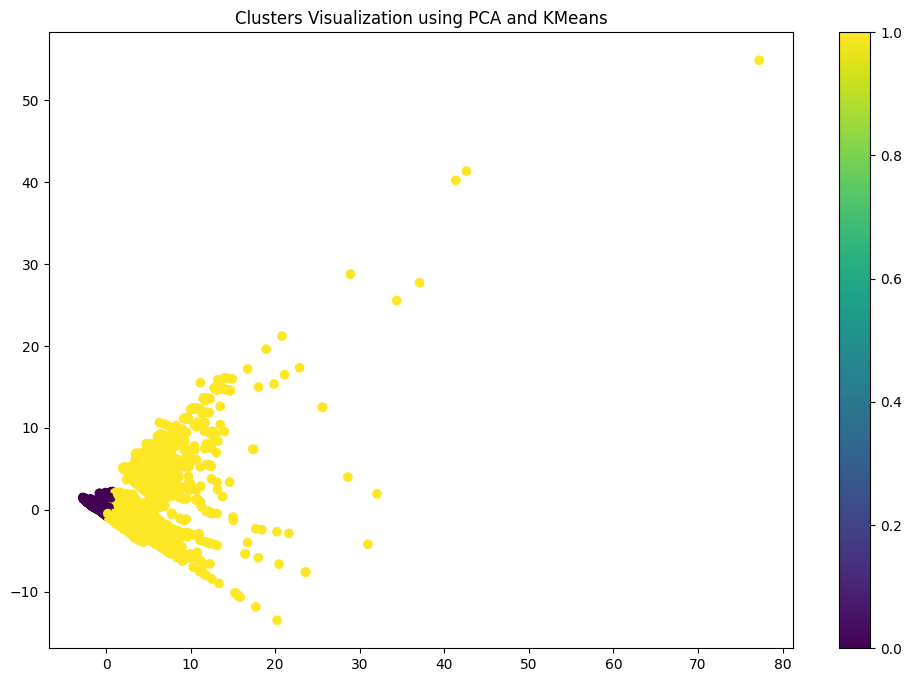

In [7]:
# Plot clusters
plt.figure(figsize=(12, 8))
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=kcluster_labels, cmap='viridis')
plt.title('Clusters Visualization using PCA and KMeans')
plt.colorbar(scatter)
plt.show()

In [11]:
# Analyze cluster distribution
cluster_counts = pd.Series(kcluster_labels).value_counts()
print("Cluster counts:\n", cluster_counts)

kmeans_analysis = pd.DataFrame({
    'original_label': balanced_df['label'],
    'cluster_label': kcluster_labels
})

kcluster_label_counts = kmeans_analysis.groupby('cluster_label')['original_label'].value_counts().unstack(fill_value=0)
print("KMeans Cluster Analysis (Before Re-mapping):\n", kcluster_label_counts)

# Determine which cluster corresponds to phishing
phishing_dominant_cluster = kcluster_label_counts['phishing'].idxmax()
non_phishing_cluster = kcluster_label_counts['legitimate'].idxmax()

# Ensure phishing cases are in cluster 0
relabel_map = {phishing_dominant_cluster: 0, non_phishing_cluster: 1}
kmeans_analysis['cluster_label'] = kmeans_analysis['cluster_label'].map(relabel_map)

# Re-map cluster labels in the original kcluster_labels array
kcluster_labels = np.array([relabel_map[label] for label in kcluster_labels])

# Recalculate cluster distribution after re-labeling
kcluster_label_counts = kmeans_analysis.groupby('cluster_label')['original_label'].value_counts().unstack(fill_value=0)
print("KMeans Cluster Analysis (After Re-mapping):\n", kcluster_label_counts)

Cluster counts:
 1    60509
0    39491
Name: count, dtype: int64
KMeans Cluster Analysis (Before Re-mapping):
 original_label  legitimate  phishing
cluster_label                       
0                     6421     33070
1                    43579     16930
KMeans Cluster Analysis (After Re-mapping):
 original_label  legitimate  phishing
cluster_label                       
0                     6421     33070
1                    43579     16930


In [ ]:
def calculate_metrics_from_confusion_matrix(confusion_matrix):
    # Extract confusion matrix values
    TP = confusion_matrix['TP']
    TN = confusion_matrix['TN']
    FP = confusion_matrix['FP']
    FN = confusion_matrix['FN']
    
    # Create true and predicted labels based on confusion matrix
    true_labels = [1] * TP + [1] * FN + [0] * TN + [0] * FP
    predicted_labels = [1] * TP + [0] * FN + [0] * TN + [1] * FP
    
    # Calculate metrics
    accuracy = (TP + TN) / (TP + TN + FP + FN)
    precision = precision_score(true_labels, predicted_labels)
    recall = recall_score(true_labels, predicted_labels)
    f1 = f1_score(true_labels, predicted_labels)
    
    # Return results
    return {
        "Accuracy": accuracy,
        "Precision": precision,
        "Recall": recall,
        "F1 Score": f1
    }




Metrics:
 {'Accuracy': 0.76649, 'Precision': 0.83740599123851, 'Recall': 0.6614, 'F1 Score': 0.7390687331686986}


In [ ]:
confusion_matrix = {
    "TP": kcluster_label_counts.loc[0, 'phishing'],
    "TN": kcluster_label_counts.loc[1, 'legitimate'],
    "FP": kcluster_label_counts.loc[0, 'legitimate'],
    "FN": kcluster_label_counts.loc[1, 'phishing']
}

metrics = calculate_metrics_from_confusion_matrix(confusion_matrix)
print("Metrics:\n", metrics)

Metrics:
 {'Accuracy': 0.76649, 'Precision': 0.83740599123851, 'Recall': 0.6614, 'F1 Score': 0.7390687331686986}


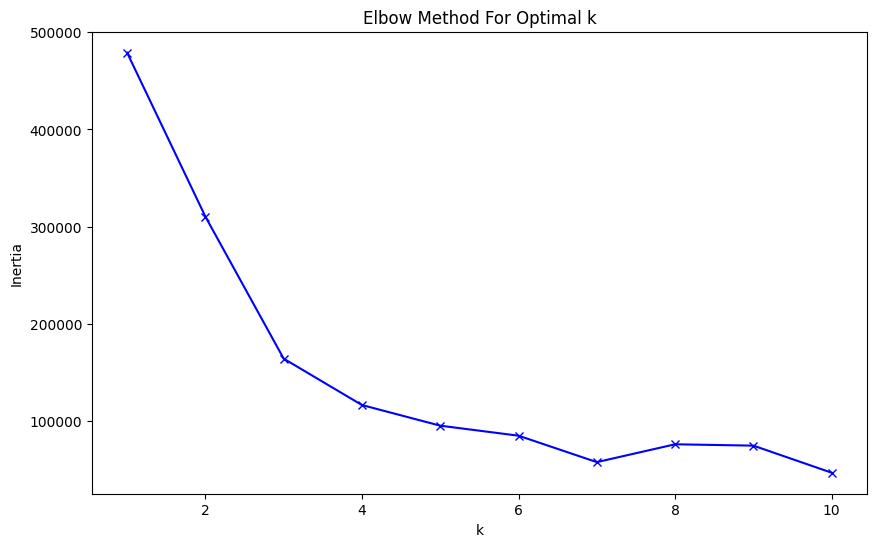

In [13]:
# Determine optimal number of clusters using elbow method
inertias = []
K = range(1, 11)

for k in K:
    kmeans = KMeans(n_clusters=k, n_init=1, init='random')
    kmeans.fit(X_pca)
    inertias.append(kmeans.inertia_)

# Plot elbow curve
plt.figure(figsize=(10, 6))
plt.plot(K, inertias, 'bx-')
plt.xlabel('k')
plt.ylabel('Inertia')
plt.title('Elbow Method For Optimal k')
plt.show()

In [17]:
# using 3 or 7 clusters as seen from elbow method
kmeans3 = KMeans(n_clusters=3, n_init=1, init='random')
kcluster_labels3 = kmeans3.fit_predict(X_pca)

kmeans7 = KMeans(n_clusters=7, n_init=1, init='random')
kcluster_labels7 = kmeans7.fit_predict(X_pca)

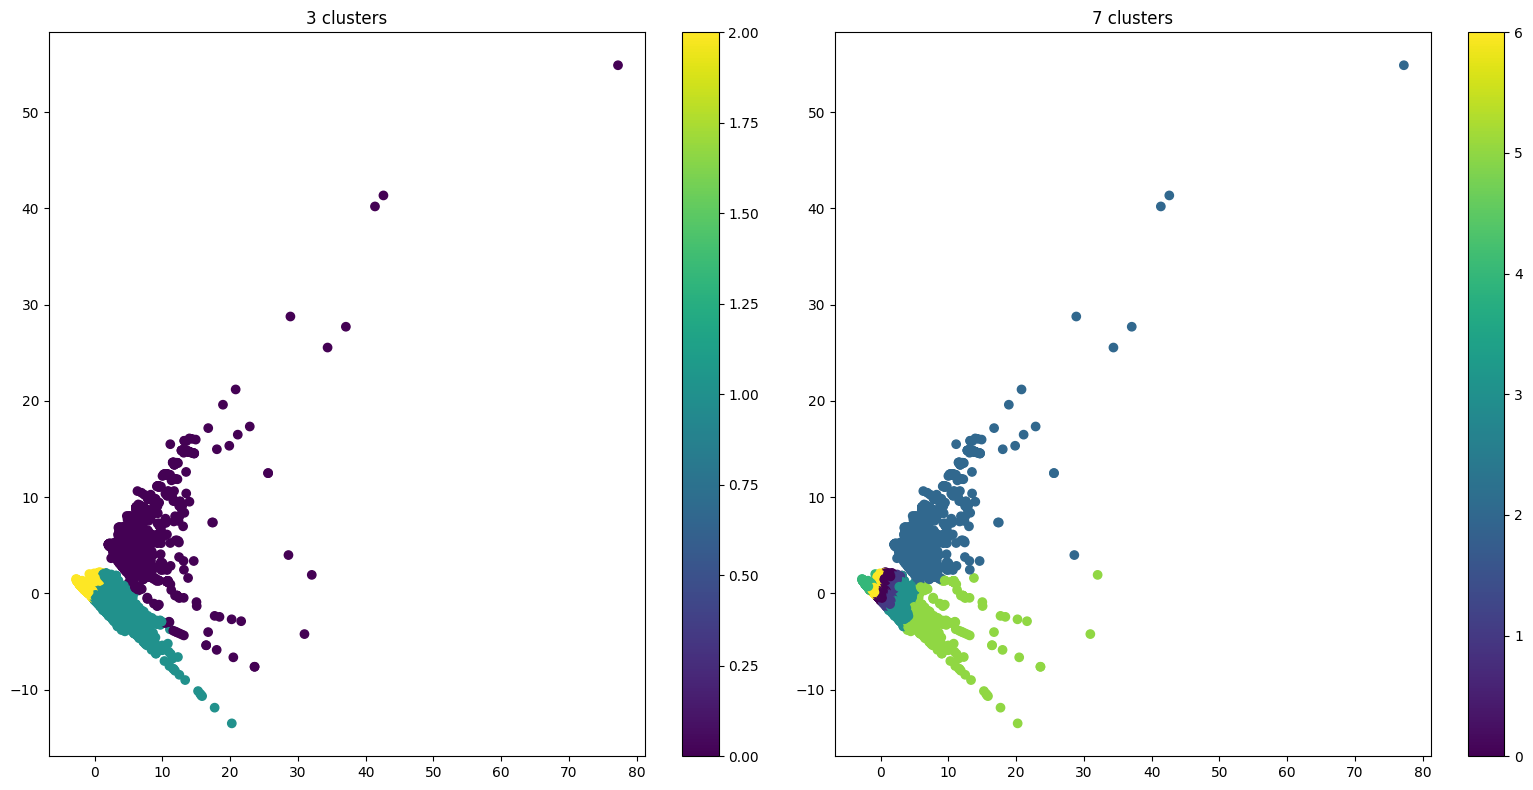

In [33]:
# # Plot clusters
# plt.figure(figsize=(12, 8))
# scatter1 = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=kcluster_labels1, cmap='viridis')
# plt.title('Clusters Visualization using PCA and KMeans')
# plt.colorbar(scatter1)
# plt.show()

# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(16, 8))

# Plot 1: Original cluster visualization
scatter1 = axes[0].scatter(X_pca[:, 0], X_pca[:, 1], c=kcluster_labels3, cmap='viridis')
axes[0].set_title('3 clusters')
fig.colorbar(scatter1, ax=axes[0])

# Plot 2: Re-mapped cluster visualization
scatter2 = axes[1].scatter(X_pca[:, 0], X_pca[:, 1], c=kcluster_labels7, cmap='viridis')
axes[1].set_title('7 clusters')
fig.colorbar(scatter2, ax=axes[1])

# Show plots
plt.tight_layout()
plt.show()



In [34]:
# Create a DataFrame with the original labels and the kmeans cluster labels
print("KMeans 3 Cluster Analysis")
kmeans_analysis3 = pd.DataFrame({
    'original_label': balanced_df['label'],
    'cluster_label': kcluster_labels3
})

# Group by cluster label and count the occurrences of each original label
kcluster_label_counts3 = kmeans_analysis3.groupby('cluster_label')['original_label'].value_counts().unstack(fill_value=0)

# Print the counts to see which cluster label corresponds to which original label
print(kcluster_label_counts3)

print("\nKMeans 7 Cluster Analysis")
kmeans_analysis7 = pd.DataFrame({
    'original_label': balanced_df['label'],
    'cluster_label': kcluster_labels7
})

# Group by cluster label and count the occurrences of each original label
kcluster_label_counts7 = kmeans_analysis7.groupby('cluster_label')['original_label'].value_counts().unstack(fill_value=0)

# Print the counts to see which cluster label corresponds to which original label
print(kcluster_label_counts7)

KMeans 3 Cluster Analysis
original_label  legitimate  phishing
cluster_label                       
0                        0      2797
1                     8065     34945
2                    41935     12258

KMeans 7 Cluster Analysis
original_label  legitimate  phishing
cluster_label                       
0                     5878     18144
1                     3539     15761
2                        0      2712
3                     1485      8713
4                    26224         1
5                      134       901
6                    12740      3768


In [31]:
def merge_clusters_to_two_labels(cluster_labels, original_labels):
    # Create a DataFrame for analysis
    cluster_analysis = pd.DataFrame({
        'original_label': original_labels,
        'cluster_label': cluster_labels
    })

    # Count occurrences of each original label within each cluster
    cluster_counts = cluster_analysis.groupby('cluster_label')['original_label'].value_counts().unstack(fill_value=0)
    print("Cluster Counts Before Merging:\n", cluster_counts)

    # Determine which clusters should be merged into phishing (0) and legitimate (1)
    phishing_clusters = []
    legitimate_clusters = []

    for cluster, counts in cluster_counts.iterrows():
        if counts['phishing'] > counts['legitimate']:
            phishing_clusters.append(cluster)
        else:
            legitimate_clusters.append(cluster)

    # Create a mapping to merge clusters into two final labels
    cluster_mapping = {cluster: 0 for cluster in phishing_clusters}  # Phishing = 0
    cluster_mapping.update({cluster: 1 for cluster in legitimate_clusters})  # Legitimate = 1

    return cluster_mapping, cluster_counts

Cluster Counts Before Merging:
 original_label  legitimate  phishing
cluster_label                       
0                        0      2797
1                     8065     34945
2                    41935     12258
Cluster Mapping After Merging: {0: 0, 1: 0, 2: 1}
Cluster Counts Before Merging:
 original_label  legitimate  phishing
cluster_label                       
0                     5878     18144
1                     3539     15761
2                        0      2712
3                     1485      8713
4                    26224         1
5                      134       901
6                    12740      3768
Cluster Mapping After Merging: {0: 0, 1: 0, 2: 0, 3: 0, 5: 0, 4: 1, 6: 1}


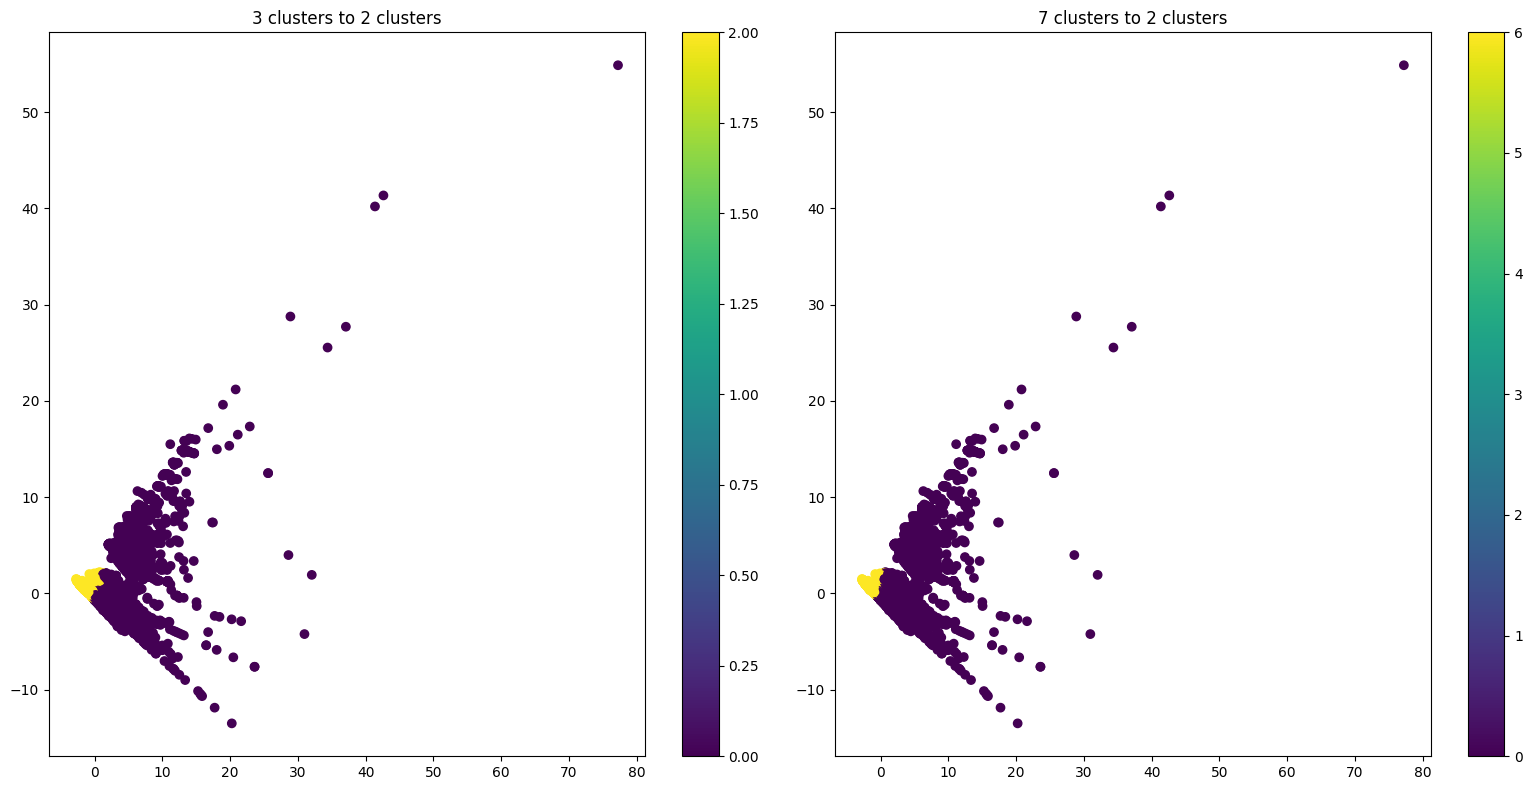

In [ ]:
# # # Create a new column to assign labels to the clusters

# # legitimate_clusters = [1]
# # phishing_clusters = [0, 2]

# clustered_df3 = pd.DataFrame({
#     'original_label': balanced_df['label'],
#     'cluster_label': kcluster_labels3
# })

# # clustered_df['assigned_label'] = clustered_df['cluster_label'].apply(lambda x: 0 if x in legitimate_clusters else 1 if x in phishing_clusters else 2)

# # # Create a custom colormap with specific colors for each label
# # cmap = mcolors.ListedColormap(['blue', 'yellow', 'green'])

# # # Plot the assigned labels
# # plt.figure(figsize=(12, 8))
# # scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=clustered_df['assigned_label'], cmap=cmap)
# # plt.title('Assigned Labels using PCA and KMeans')
# # plt.colorbar(scatter)
# # plt.show()
# # Analyze the distribution of original labels within each cluster
# def assign_clusters_by_majority(cluster_labels, original_labels):
#     # Create a DataFrame for analysis
#     cluster_analysis = pd.DataFrame({
#         'original_label': original_labels,
#         'cluster_label': cluster_labels
#     })

#     # Count occurrences of each original label within each cluster
#     cluster_counts = cluster_analysis.groupby('cluster_label')['original_label'].value_counts().unstack(fill_value=0)

#     # Dynamically assign phishing (0) and legitimate (1) based on majority
#     cluster_mapping = {}
#     for cluster, counts in cluster_counts.iterrows():
#         # Assign 0 to phishing and 1 to legitimate based on the higher count
#         if counts['phishing'] > counts['legitimate']:
#             cluster_mapping[cluster] = 0  # Phishing
#         else:
#             cluster_mapping[cluster] = 1  # Legitimate

#     return cluster_mapping, cluster_counts

# # Dynamically map cluster labels
# cluster_mapping, cluster_counts = assign_clusters_by_majority(kcluster_labels3, balanced_df['label'])
# print("Cluster to Assigned Label Mapping:", cluster_mapping)

# # Map the cluster labels in the dataset
# clustered_df3['assigned_label'] = clustered_df3['cluster_label'].map(cluster_mapping)

# # Visualize the dynamically assigned labels
# cmap = mcolors.ListedColormap(['yellow', 'blue'])  # Yellow for phishing (0), Blue for legitimate (1)

# plt.figure(figsize=(12, 8))
# scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=clustered_df3['assigned_label'], cmap=cmap)
# plt.title('Dynamically Assigned Labels using PCA and KMeans')
# plt.colorbar(scatter, ticks=[0, 1], label='Assigned Labels (0=Phishing, 1=Legitimate)')
# plt.show()

# # Print the updated cluster counts after dynamic assignment
# print("Updated Cluster Counts:\n", cluster_counts)
# Analyze cluster distribution and merge clusters dynamically




# 3 clusters
# Merge clusters dynamically
cluster_mapping3, cluster_counts3 = merge_clusters_to_two_labels(kcluster_labels3, balanced_df['label'])

# Apply the mapping to assign final labels
clustered_df3 = pd.DataFrame({
    'original_label': balanced_df['label'],
    'cluster_label': kcluster_labels3
})
clustered_df3['assigned_label'] = clustered_df3['cluster_label'].map(cluster_mapping3)




#7 clusters
cluster_mapping7, cluster_counts7 = merge_clusters_to_two_labels(kcluster_labels7, balanced_df['label'])

# Apply the mapping to assign final labels
clustered_df7 = pd.DataFrame({
    'original_label': balanced_df['label'],
    'cluster_label': kcluster_labels7
})
clustered_df7['assigned_label'] = clustered_df7['cluster_label'].map(cluster_mapping7)



# Visualize the assigned labels
cmap = mcolors.ListedColormap(['yellow', 'blue'])  # Yellow for phishing (0), Blue for legitimate (1)

# plt.figure(figsize=(12, 8))
# scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=clustered_df3['assigned_label'], cmap=cmap)
# plt.title('Kmeans 3 clusters using PCA and KMeans')
# plt.colorbar(scatter, ticks=[0, 1], label='Assigned Labels (0=Phishing, 1=Legitimate)')
# plt.show()

# # Print the updated cluster counts after merging
# final_counts = clustered_df3.groupby('assigned_label')['original_label'].value_counts().unstack(fill_value=0)
# print("Final Cluster Counts After Merging:\n", final_counts)

# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(16, 8))

# Plot 1: 3 cluster visualization
scatter3 = axes[0].scatter(X_pca[:, 0], X_pca[:, 1], c=clustered_df3['assigned_label'], cmap='viridis')
axes[0].set_title('3 clusters to 2 clusters')
fig.colorbar(scatter1, ax=axes[0])

# Plot 2: 7 cluster visualization
scatter7 = axes[1].scatter(X_pca[:, 0], X_pca[:, 1], c=clustered_df7['assigned_label'], cmap='viridis')
axes[1].set_title('7 clusters to 2 clusters')
fig.colorbar(scatter2, ax=axes[1])

# Show plots
plt.tight_layout()
plt.show()


In [ ]:
# Count the number of legitimate and phishing labels in each assigned cluster
cluster_counts3 = clustered_df3.groupby('assigned_label')['original_label'].value_counts().unstack(fill_value=0)
cluster_counts7 = clustered_df7.groupby('assigned_label')['original_label'].value_counts().unstack(fill_value=0)

# Print the counts
print("3 clusters to 2 clusters\n",clustered_df3.groupby('assigned_label')['original_label'].value_counts().unstack(fill_value=0))
print("\n7 clusters to 2 clusters\n",clustered_df7.groupby('assigned_label')['original_label'].value_counts().unstack(fill_value=0))

3 clusters to 2 clusters
 original_label  legitimate  phishing
assigned_label                      
0                     8065     37742
1                    41935     12258

7 clusters to 2 clusters
 original_label  legitimate  phishing
assigned_label                      
0                    11036     46231
1                    38964      3769


In [49]:
confusion_matrix3 = {
    "TP": cluster_counts3.loc[0, 'phishing'],
    "TN": cluster_counts3.loc[1, 'legitimate'],
    "FP": cluster_counts3.loc[0, 'legitimate'],
    "FN": cluster_counts3.loc[1, 'phishing']
}

metrics3 = calculate_metrics_from_confusion_matrix(confusion_matrix3)
print("Metrics for 3 clusters:\n", metrics3)

confusion_matrix7 = {
    "TP": cluster_counts7.loc[0, 'phishing'],
    "TN": cluster_counts7.loc[1, 'legitimate'],
    "FP": cluster_counts7.loc[0, 'legitimate'],
    "FN": cluster_counts7.loc[1, 'phishing']
}
metrics7 = calculate_metrics_from_confusion_matrix(confusion_matrix7)
print("Metrics for 7 clusters:\n", metrics7)

Metrics for 3 clusters:
 {'Accuracy': 0.79677, 'Precision': 0.8239352064095007, 'Recall': 0.75484, 'F1 Score': 0.7878756249543353}
Metrics for 7 clusters:
 {'Accuracy': 0.85195, 'Precision': 0.807288665374474, 'Recall': 0.92462, 'F1 Score': 0.8619799192668761}


Here, we see 7 cluster is more reliable over 3 cluster, although 3 clusters has better precision

Evaluating KMeans Clusters: 100%|██████████| 9/9 [13:02<00:00, 86.98s/it]
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed i

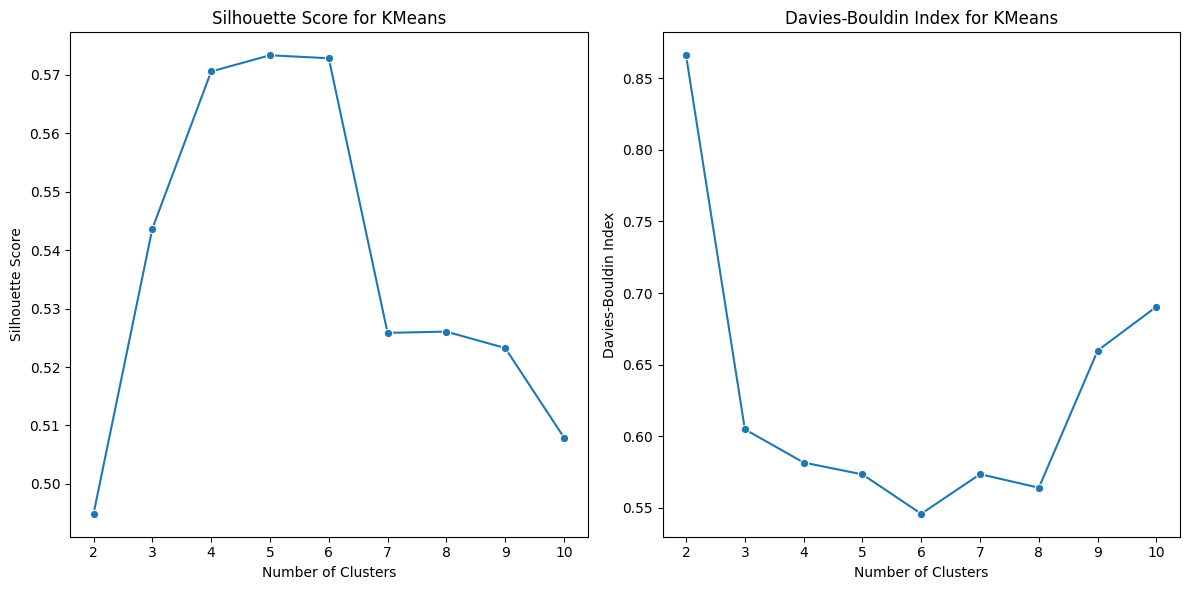

Best number of clusters based on Silhouette Score: 5 (Score: 0.5734)
Best number of clusters based on Davies-Bouldin Index: 6 (Score: 0.5458)


In [ ]:
# Step 1: Evaluate KMeans for a range of cluster numbers
def evaluate_kmeans(X_pca, cluster_range):
    silhouette_scores = []
    db_scores = []
    results = []

    for k in tqdm(cluster_range, desc="Evaluating KMeans Clusters"):
        kmeans = KMeans(n_clusters=k, n_init=1, init='random')
        labels = kmeans.fit_predict(X_pca)
        
        # Compute Silhouette Score and Davies-Bouldin Index
        silhouette = silhouette_score(X_pca, labels) if k > 1 else -1  # Silhouette not valid for k=1
        db_index = davies_bouldin_score(X_pca, labels) if k > 1 else float('inf')
        
        silhouette_scores.append(silhouette)
        db_scores.append(db_index)
        
        results.append((k, silhouette, db_index))

    return results, silhouette_scores, db_scores

# Step 2: Define cluster range and compute metrics
cluster_range = range(2, 11)  # Test cluster sizes from 2 to 10
results, silhouette_scores, db_scores = evaluate_kmeans(X_pca, cluster_range)

# Convert results to DataFrame for easier plotting
results_df = pd.DataFrame(results, columns=['Clusters', 'Silhouette Score', 'Davies-Bouldin Index'])

# Step 3: Plot the metrics
plt.figure(figsize=(12, 6))

# Plot Silhouette Score
plt.subplot(1, 2, 1)
sns.lineplot(data=results_df, x='Clusters', y='Silhouette Score', marker='o')
plt.title('Silhouette Score for KMeans')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')

# Plot Davies-Bouldin Index
plt.subplot(1, 2, 2)
sns.lineplot(data=results_df, x='Clusters', y='Davies-Bouldin Index', marker='o')
plt.title('Davies-Bouldin Index for KMeans')
plt.xlabel('Number of Clusters')
plt.ylabel('Davies-Bouldin Index')

plt.tight_layout()
plt.show()

# Step 4: Print the best results
best_silhouette_index = results_df['Silhouette Score'].idxmax()
best_silhouette_clusters = results_df.loc[best_silhouette_index, 'Clusters']
best_silhouette_score = results_df.loc[best_silhouette_index, 'Silhouette Score']

best_db_index = results_df['Davies-Bouldin Index'].idxmin()
best_db_clusters = results_df.loc[best_db_index, 'Clusters']
best_db_score = results_df.loc[best_db_index, 'Davies-Bouldin Index']

print(f"Best number of clusters based on Silhouette Score: {best_silhouette_clusters} (Score: {best_silhouette_score:.4f})")
print(f"Best number of clusters based on Davies-Bouldin Index: {best_db_clusters} (Score: {best_db_score:.4f})")

In [59]:
# Best number of clusters based on Silhouette Score: 5 (Score: 0.5734)
kmeans5 = KMeans(n_clusters=5, n_init=1, init='random')
kcluster_labels5 = kmeans5.fit_predict(X_pca)
# Create a DataFrame with the original labels and the kmeans cluster labels
kmeans_analysis5 = pd.DataFrame({
    'original_label': balanced_df['label'],
    'cluster_label': kcluster_labels5
})
cluster_mapping5, cluster_counts5 = merge_clusters_to_two_labels(kcluster_labels5, balanced_df['label'])

# Apply the mapping to assign final labels
clustered_df5 = pd.DataFrame({
    'original_label': balanced_df['label'],
    'cluster_label': kcluster_labels5
})
clustered_df5['assigned_label'] = clustered_df5['cluster_label'].map(cluster_mapping5)

cluster_counts5 = clustered_df5.groupby('assigned_label')['original_label'].value_counts().unstack(fill_value=0)

# Print the counts
print("\n5 clusters to 2 clusters\n",cluster_counts5)


# Define confusion matrix values
confusion_matrix5 = {
    "TP": cluster_counts5.loc[0, 'phishing'],
    "TN": cluster_counts5.loc[1, 'legitimate'],
    "FP": cluster_counts5.loc[0, 'legitimate'],
    "FN": cluster_counts5.loc[1, 'phishing']
}

# Calculate metrics
metrics5 = calculate_metrics_from_confusion_matrix(confusion_matrix5)
print("Metrics for 5 clusters:\n", metrics5)

Cluster Counts Before Merging:
 original_label  legitimate  phishing
cluster_label                       
0                      172      1087
1                        0      2712
2                    36494      1714
3                     2582     14265
4                    10752     30222

5 clusters to 2 clusters
 original_label  legitimate  phishing
assigned_label                      
0                    13506     48286
1                    36494      1714
Metrics for 5 clusters:
 {'Accuracy': 0.8478, 'Precision': 0.7814280165717244, 'Recall': 0.96572, 'F1 Score': 0.8638543008444253}


In [ ]:
# Best number of clusters based on Davies-Bouldin Index: 6 (Score: 0.5458)
kmeans6 = KMeans(n_clusters=6, n_init=1, init='random')
kcluster_labels6 = kmeans6.fit_predict(X_pca)
# Create a DataFrame with the original labels and the kmeans cluster labels
kmeans_analysis6 = pd.DataFrame({
    'original_label': balanced_df['label'],
    'cluster_label': kcluster_labels6
})
cluster_mapping6, cluster_counts6 = merge_clusters_to_two_labels(kcluster_labels6, balanced_df['label'])

# Apply the mapping to assign final labels
clustered_df6 = pd.DataFrame({
    'original_label': balanced_df['label'],
    'cluster_label': kcluster_labels6
})
clustered_df6['assigned_label'] = clustered_df6['cluster_label'].map(cluster_mapping6)

cluster_counts6 = clustered_df6.groupby('assigned_label')['original_label'].value_counts().unstack(fill_value=0)

# Print the counts
print("\n6 clusters to 2 clusters\n",cluster_counts6)


# Define confusion matrix values
confusion_matrix6 = {
    "TP": cluster_counts6.loc[0, 'phishing'],
    "TN": cluster_counts6.loc[1, 'legitimate'],
    "FP": cluster_counts6.loc[0, 'legitimate'],
    "FN": cluster_counts6.loc[1, 'phishing']
}

# Calculate metrics
metrics6 = calculate_metrics_from_confusion_matrix(confusion_matrix6)
print("Metrics for 6 clusters:\n", metrics6)

Cluster Counts Before Merging:
 original_label  legitimate  phishing
cluster_label                       
0                        0      2712
1                     5657     21560
2                    11810     13674
3                     1839     11035
4                      146       981
5                    30548        38

6 clusters to 2 clusters
 original_label  legitimate  phishing
assigned_label                      
0                    19452     49962
1                    30548        38
Metrics for 6 clusters:
 {'Accuracy': 0.8051, 'Precision': 0.7197683464430806, 'Recall': 0.99924, 'F1 Score': 0.8367863064632288}


**Both Silhouette score and Davies-Bouldin give us better results than the elbow method**

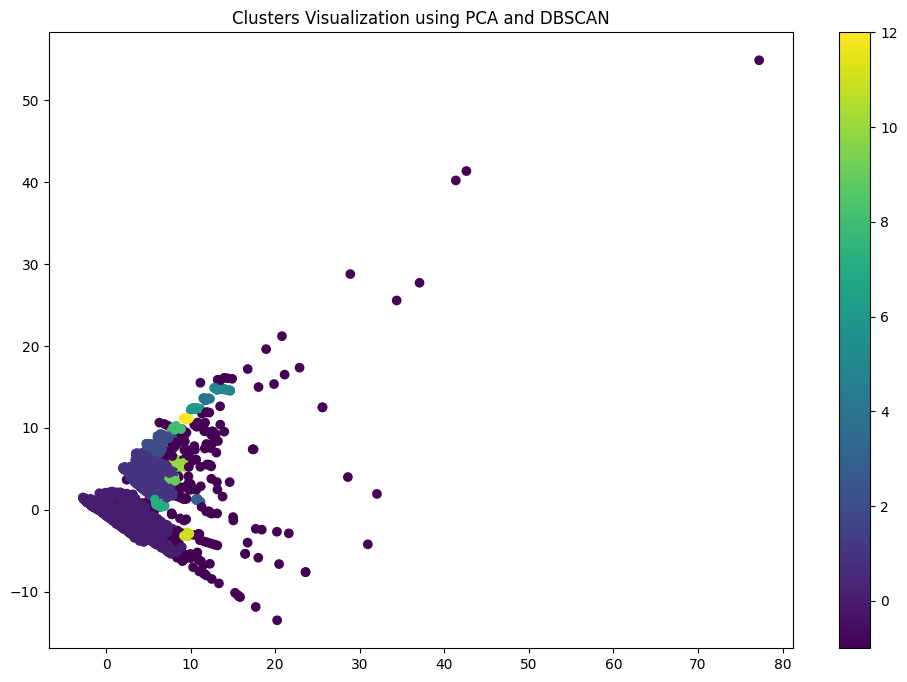

In [ ]:
# Apply DBSCAN clustering
dbscan = DBSCAN(eps=0.5, min_samples=10)
dbscan_labels = dbscan.fit_predict(X_pca)

# Plot clusters using DBSCAN
plt.figure(figsize=(12, 8))
scatter2 = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=dbscan_labels, cmap='viridis')
plt.title('Clusters Visualization using PCA and DBSCAN')
plt.colorbar(scatter2)
plt.show()

In [40]:
# Create a DataFrame with the original labels and the DBSCAN cluster labels
dbscan_analysis = pd.DataFrame({
    'original_label': balanced_df['label'],
    'cluster_label': dbscan_labels
})

# Group by cluster label and count the occurrences of each original label
dbscan_label_counts = dbscan_analysis.groupby('cluster_label')['original_label'].value_counts().unstack(fill_value=0)

# Print the counts to see which cluster label corresponds to which original label
print(dbscan_label_counts)

original_label  legitimate  phishing
cluster_label                       
-1                      17       220
 0                   49983     47158
 1                       0      2219
 2                       0       186
 3                       0        20
 4                       0        15
 5                       0        68
 6                       0        18
 7                       0        18
 8                       0        19
 9                       0        14
 10                      0        24
 11                      0        10
 12                      0        11


The clustering here using dbscan do not seem to differentiate the target classes, hence we try tuning parameters to get better clusters

eps values: 100%|██████████| 3/3 [30:45<00:00, 615.25s/it]        
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping wi

Best DBSCAN parameters based on Silhouette Score: eps=0.6, min_samples=20
Best DBSCAN parameters based on Davies-Bouldin Index: eps=0.6, min_samples=40


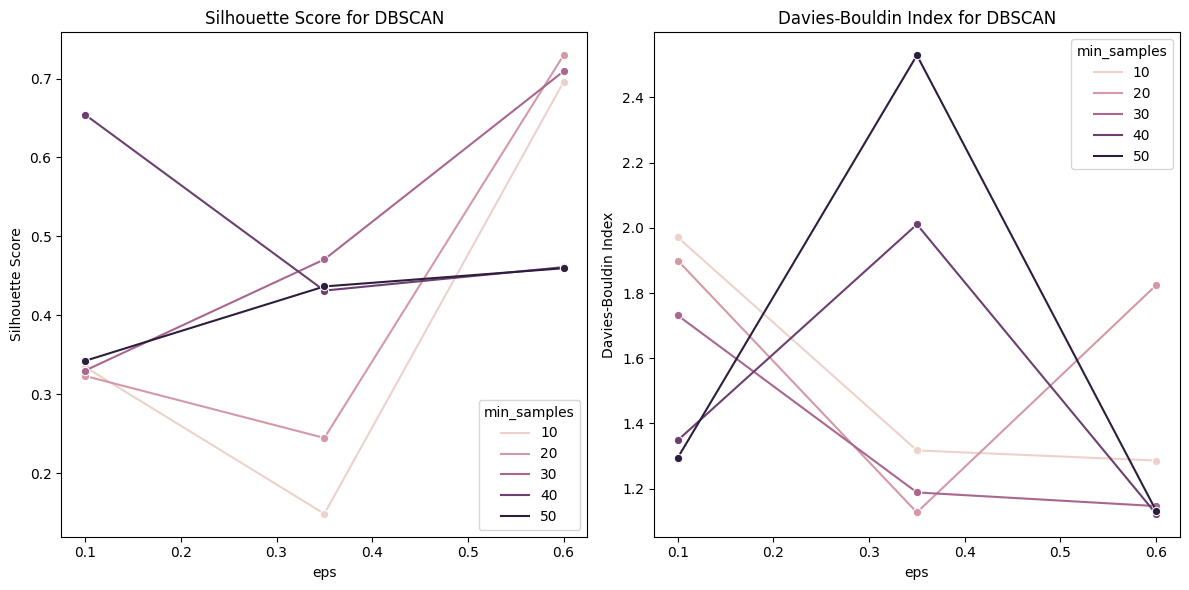

In [9]:
# Step 1: Compute the k-Nearest Neighbors distance
def compute_knn_distances(X_pca, n_neighbors):
    knn = NearestNeighbors(n_neighbors=n_neighbors)
    knn.fit(X_pca)
    distances, _ = knn.kneighbors(X_pca)
    sorted_distances = np.sort(distances[:, n_neighbors - 1])
    return sorted_distances

# Step 2: Plot the k-NN distance plot to find a suitable eps
def plot_knn_distance(X_pca, n_neighbors=10):
    sorted_distances = compute_knn_distances(X_pca, n_neighbors)
    plt.figure(figsize=(12, 8))
    plt.plot(sorted_distances)
    plt.title(f'k-NN Distance Plot (k={n_neighbors})')
    plt.xlabel('Data Points sorted by distance')
    plt.ylabel(f'Distance to {n_neighbors}-th nearest neighbor')
    plt.grid(True)
    plt.show()

# Step 3: Automatic selection of eps and min_samples based on Silhouette Score or Davies-Bouldin Index
def dbscan_auto_select(X_pca, eps_values, min_samples_range):
    best_silhouette = -1
    best_db_index = float('inf')
    best_params_silhouette = {}
    best_params_db_index = {}
    results = []

    for eps in tqdm(eps_values, desc="eps values"):
        for min_samples in tqdm(min_samples_range, desc="min_samples values", leave=False):
            dbscan = DBSCAN(eps=eps, min_samples=min_samples)
            clusters = dbscan.fit_predict(X_pca)

            if len(np.unique(clusters)) > 1:
                silhouette = silhouette_score(X_pca, clusters)
                db_index = davies_bouldin_score(X_pca, clusters)
                results.append((eps, min_samples, silhouette, db_index))

                if silhouette > best_silhouette:
                    best_silhouette = silhouette
                    best_params_silhouette = {'eps': eps, 'min_samples': min_samples}

                if db_index < best_db_index:
                    best_db_index = db_index
                    best_params_db_index = {'eps': eps, 'min_samples': min_samples}

    return results, best_params_silhouette, best_params_db_index

# Step 4: Automatically choose the best eps and min_samples values based on performance metrics
eps_values = np.linspace(0.1, 0.6, 3)
min_samples_range = range(10, 60, 10)

# Experiment with different n_neighbors values
n_neighbors_values = [2, 3, 5, 10]

# for n_neighbors in n_neighbors_values:
#     print(f"Plotting k-NN distance plot for n_neighbors={n_neighbors}")
#     plot_knn_distance(X_pca, n_neighbors)

results, best_params_silhouette, best_params_db_index = dbscan_auto_select(X_pca, eps_values, min_samples_range)

# Step 5: Print best DBSCAN configuration and results
print(f"Best DBSCAN parameters based on Silhouette Score: eps={best_params_silhouette['eps']}, min_samples={best_params_silhouette['min_samples']}")
print(f"Best DBSCAN parameters based on Davies-Bouldin Index: eps={best_params_db_index['eps']}, min_samples={best_params_db_index['min_samples']}")

# Step 6: Plot the Silhouette and Davies-Bouldin scores
results_df = pd.DataFrame(results, columns=['eps', 'min_samples', 'Silhouette Score', 'Davies-Bouldin Index'])

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
sns.lineplot(data=results_df, x='eps', y='Silhouette Score', hue='min_samples', marker='o')
plt.title('Silhouette Score for DBSCAN')
plt.xlabel('eps')
plt.ylabel('Silhouette Score')

plt.subplot(1, 2, 2)
sns.lineplot(data=results_df, x='eps', y='Davies-Bouldin Index', hue='min_samples', marker='o')
plt.title('Davies-Bouldin Index for DBSCAN')
plt.xlabel('eps')
plt.ylabel('Davies-Bouldin Index')

plt.tight_layout()
plt.show()

original_label  legitimate  phishing
cluster_label                       
-1                      16       335
 0                   49984     47161
 1                       0      2219
 2                       0       175
 3                       0        20
 4                       0        68
 5                       0        22


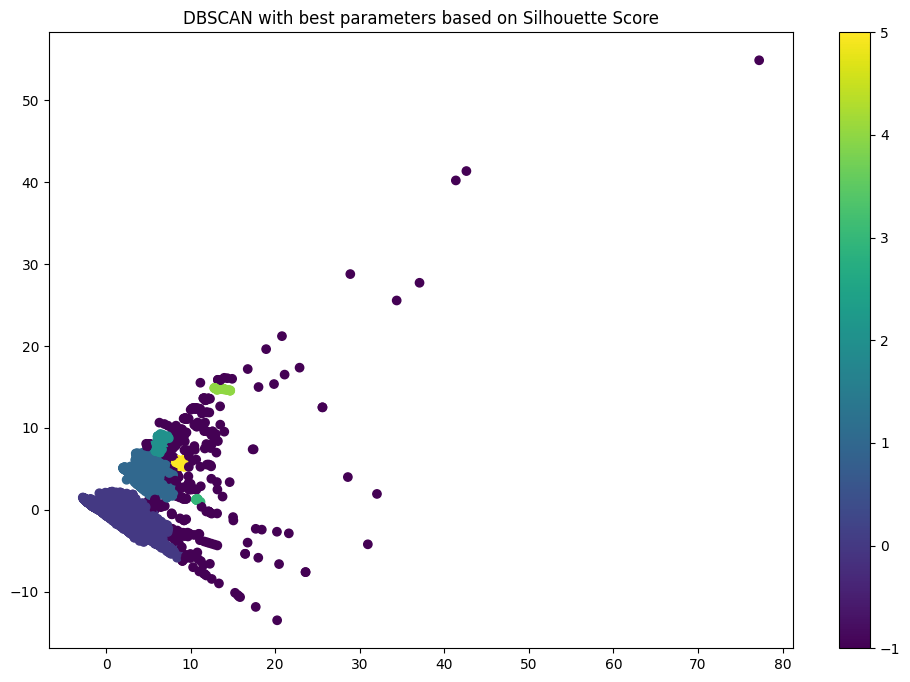

In [17]:
# Best DBSCAN parameters based on Silhouette Score: eps=0.6, min_samples=20
dbscanS = DBSCAN(eps=0.6, min_samples=20)
dbscan_labelsS = dbscanS.fit_predict(X_pca)

# Create a DataFrame with the original labels and the DBSCAN cluster labels
cluster_analysisS = pd.DataFrame({
    'original_label': balanced_df['label'],
    'cluster_label': dbscan_labelsS
})

# Group by cluster label and count the occurrences of each original label
cluster_label_countsS = cluster_analysisS.groupby('cluster_label')['original_label'].value_counts().unstack(fill_value=0)

# Print the counts to see which cluster label corresponds to which original label
print(cluster_label_countsS)

plt.figure(figsize=(12, 8))
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=dbscan_labelsS, cmap='viridis')
plt.title('DBSCAN with best parameters based on Silhouette Score')
plt.colorbar(scatter)
plt.show()

original_label  legitimate  phishing
cluster_label                       
-1                      30       474
 0                   49935     46653
 1                       0      1655
 2                       0       551
 3                      24       399
 4                       0       151
 5                      11        54
 6                       0        63


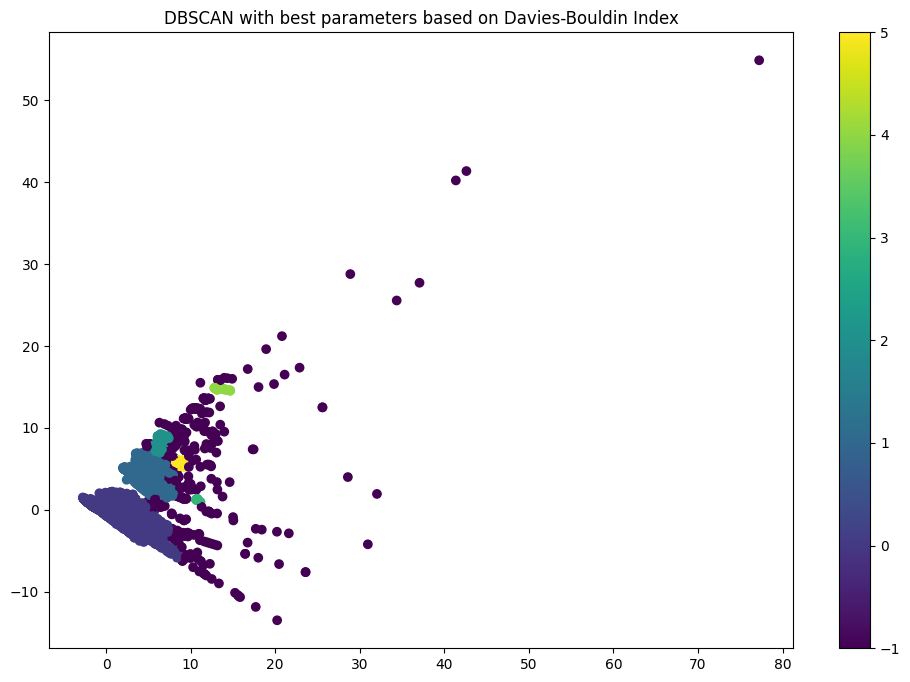

In [18]:
# Best DBSCAN parameters based on Davies-Bouldin Index: eps=0.6, min_samples=40
dbscanD = DBSCAN(eps=0.6, min_samples=40)
dbscan_labelsD = dbscanD.fit_predict(X_pca)

# Create a DataFrame with the original labels and the DBSCAN cluster labels
cluster_analysisD = pd.DataFrame({
    'original_label': balanced_df['label'],
    'cluster_label': dbscan_labelsD
})

# Group by cluster label and count the occurrences of each original label
cluster_label_countsD = cluster_analysisD.groupby('cluster_label')['original_label'].value_counts().unstack(fill_value=0)

# Print the counts to see which cluster label corresponds to which original label
print(cluster_label_countsD)

plt.figure(figsize=(12, 8))
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=dbscan_labelsS, cmap='viridis')
plt.title('DBSCAN with best parameters based on Davies-Bouldin Index')
plt.colorbar(scatter)
plt.show()

**We see most of both legitimate and phishing are still assigned to one cluster and hence DBSCAN, even with the best params are not suitable for this dataset.**

Clustering Progress: 100%|██████████| 5/5 [00:22<00:00,  4.48s/it]


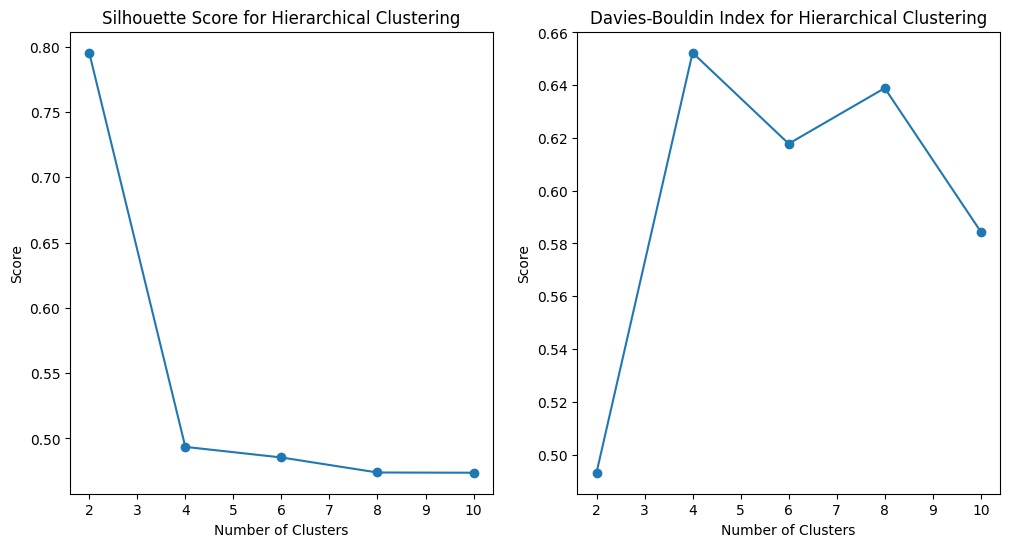

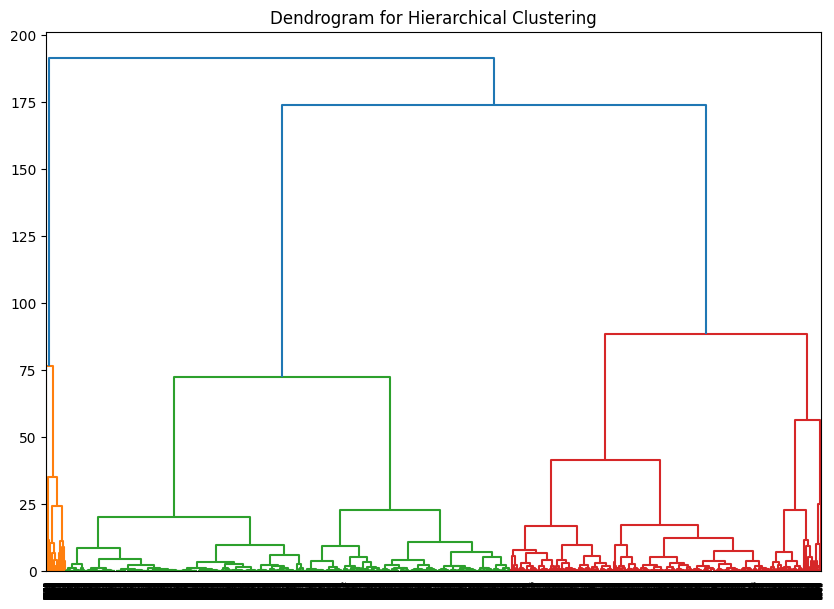

Best number of clusters based on Silhouette Score: 2 (Score: 0.7955)
Best number of clusters based on Davies-Bouldin Index: 2 (Score: 0.4931)


In [4]:
# Step 1: Perform Agglomerative Clustering
def hierarchical_clustering(X_pca1, num_clusters, linkage_method='ward'):
    hc = AgglomerativeClustering(n_clusters=num_clusters, linkage=linkage_method)
    return hc.fit_predict(X_pca1)

# Step 2: Evaluate the clustering using Silhouette Score and Davies-Bouldin Index
def evaluate_clustering(X_pca1, cluster_labels):
    return silhouette_score(X_pca1, cluster_labels), davies_bouldin_score(X_pca1, cluster_labels)

# Step 3: Run experiments with different numbers of clusters
num_clusters_range = range(2, 12, 2)
sil_scores = []
db_scores = []

for k in tqdm(num_clusters_range, desc="Clustering Progress"):
    cluster_labels = hierarchical_clustering(X_pca1, k)
    sil_score, db_score = evaluate_clustering(X_pca1, cluster_labels)
    sil_scores.append(sil_score)
    db_scores.append(db_score)

# Step 4: Plot the results
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(num_clusters_range, sil_scores, marker='o')
plt.title('Silhouette Score for Hierarchical Clustering')
plt.xlabel('Number of Clusters')
plt.ylabel('Score')

plt.subplot(1, 2, 2)
plt.plot(num_clusters_range, db_scores, marker='o')
plt.title('Davies-Bouldin Index for Hierarchical Clustering')
plt.xlabel('Number of Clusters')
plt.ylabel('Score')
plt.show()

# Step 5: Visualize Dendrogram (for linkage='ward', 'complete', or 'average')
plt.figure(figsize=(10, 7))
Z = linkage(X_pca1, method='ward')
dendrogram(Z)
plt.title('Dendrogram for Hierarchical Clustering')
plt.show()

# Step 6: Determine the best parameters
best_silhouette_index = np.argmax(sil_scores)
best_silhouette_clusters = num_clusters_range[best_silhouette_index]
best_silhouette_score = sil_scores[best_silhouette_index]

best_davies_bouldin_index = np.argmin(db_scores)
best_davies_bouldin_clusters = num_clusters_range[best_davies_bouldin_index]
best_davies_bouldin_score = db_scores[best_davies_bouldin_index]

print(f"Best number of clusters based on Silhouette Score: {best_silhouette_clusters} (Score: {best_silhouette_score:.4f})")
print(f"Best number of clusters based on Davies-Bouldin Index: {best_davies_bouldin_clusters} (Score: {best_davies_bouldin_score:.4f})")

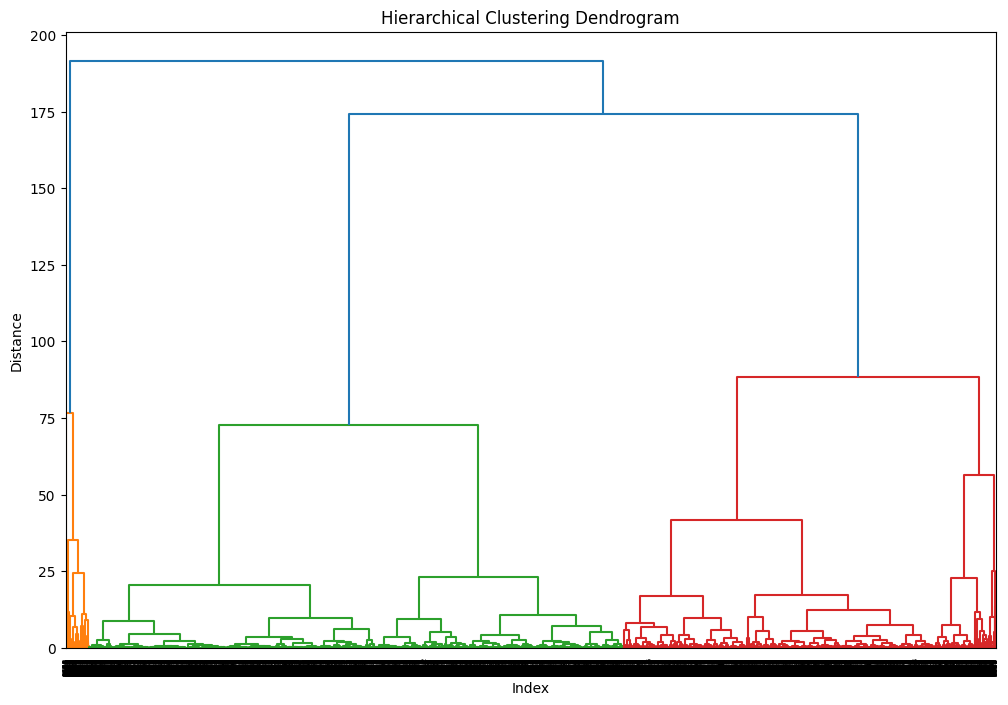

original_label  legitimate  phishing
cluster_label                       
0                     5000      4753
1                        0       247


In [19]:
hclust = AgglomerativeClustering(n_clusters=2, linkage='ward')
hclust_labels = hclust.fit_predict(X_pca1)

plt.figure(figsize=(12, 8))
dendrogram(linkage(X_pca1, method='ward'))
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('Index')
plt.ylabel('Distance')
plt.show()


# Create a DataFrame with the original labels and the cluster labels
hcluster_analysis = pd.DataFrame({
    'original_label': balanced_df1['label'],
    'cluster_label': hclust_labels
})

# Group by cluster label and count the occurrences of each original label
hcluster_label_counts = hcluster_analysis.groupby('cluster_label')['original_label'].value_counts().unstack(fill_value=0)

# Print the counts to see which cluster label corresponds to which original label
print(hcluster_label_counts)

**Here, we see that even hierarchical clustering fails for our dataset, where even the best parameters cannot identify the 2 clusters separately**